# **Forward Modelling y Inversión con datos sínteticos**
**Elaborado por:** \
Ivan Camilo Caballero Jaimes 2210623\
Johan Enrique Páez Romero 2210631\
Semillero de Investigación en Geofísica Aplicada y Computacional - **SIGAC**

## Librerías

In [1]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem 
# Si sale error: cannot import name 'numpy' from 'matplotlib'
# Ir a: c:\Programas\anaconda3\envs\simpeg0170\Lib\site-packages\SimPEG\electromagnetics\natural_source\utils\plot_data_types.py
# Modificar a from matplotlib import pyplot as plt, colors
#             import numpy as np

from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14
from ipywidgets import interact, widgets
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tkinter import Tk, Button, filedialog

## Funciones

In [2]:
def run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

    #mesh_plot = mesh.plot_grid() ###

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    ### CORRECCIÓN ---
    survey = nsem.survey.Survey(source_list) ### Antes -> survey = nsem.survery.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs = dpred + noise
    return dobs, dpred

def run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=10,
    maxIterCG=30,
    alpha_s=1e-10,
    alpha_z=1,
    beta0_ratio=0.1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1
    ):
    mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    survey = nsem.Survey(source_list)

    sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layer_thicknesses_inv,
    )
    # Define the data 
    data_object = data.Data(survey, dobs=dobs, standard_deviation=standard_deviation)    
    
    # Initial model
    m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)
    
    # Reference model
    mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref)    
    
    dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

    # Define the regularization (model objective function)
    reg = regularization.Sparse(
        mesh_inv, alpha_s=alpha_s, alpha_x=alpha_z, mref=mref,
        mapping=maps.IdentityMap(mesh=mesh_inv)
    )

    # Define how the optimization problem is solved. Here we will use an inexact
    # Gauss-Newton approach that employs the conjugate gradient solver.
    opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=maxIterCG)

    # Define the inverse problem
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

    #######################################################################
    # Define Inversion Directives
    # ---------------------------
    #
    # Here we define any directives that are carried out during the inversion. This
    # includes the cooling schedule for the trade-off parameter (beta), stopping
    # criteria for the inversion and saving inversion results at each iteration.
    #

    # Defining a starting value for the trade-off parameter (beta) between the data
    # misfit and the regularization.
    starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)

    # Set the rate of reduction in trade-off parameter (beta) each time the
    # the inverse problem is solved. And set the number of Gauss-Newton iterations
    # for each trade-off paramter value.
    beta_schedule = directives.BetaSchedule(coolingFactor=coolingFactor, coolingRate=coolingRate)
    save_dictionary = directives.SaveOutputDictEveryIteration()
    save_dictionary.outDict = {}
    # Setting a stopping criteria for the inversion.
    target_misfit = directives.TargetMisfit(chifact=chi_factor)

    # The directives are defined as a list.
    directives_list = [
        starting_beta,
        beta_schedule,
        target_misfit,
        save_dictionary
    ]

    #####################################################################
    # Running the Inversion
    # ---------------------
    #
    # To define the inversion object, we need to define the inversion problem and
    # the set of directives. We can then run the inversion.
    #

    # Here we combine the inverse problem and the set of directives
    inv = inversion.BaseInversion(inv_prob, directives_list)

    # Run the inversion
    recovered_model = inv.run(m0)    
    
    return recovered_model, save_dictionary.outDict

def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

def plot_inverted_model_and_data(iteration):
    dpred = output_dict[iteration]['dpred']
    m = output_dict[iteration]['m']
    
    fig = plt.figure(figsize=(16, 5))
    gs = gridspec.GridSpec(1, 5, figure=fig)

    # Primer subplot: Modelo de resistividades invertidos
    ax0 = fig.add_subplot(gs[0, 0])
    plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", label='Verdadero')
    plot_1d_layer_model(layer_thicknesses_inv[::-1], (1./(np.exp(m)))[::-1], ax=ax0, color="k", linestyle='--', label='Predicción')
    ax0.legend()
    ax0.set_xlabel("Resistividad ($\Omega$m)")
    ax0.set_xlim(1, 15000)
    ax0.set_ylabel("Profundidad [m]")
    ax0.set_title("Modelo de resistividades invertidos")

    # Segundo subplot: Datos observados y predichos
    ax = fig.add_subplot(gs[0, 2:])
    ax.loglog(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 0], 'x', color='C0', label='Obs.-AparRho.')
    ax.loglog(1./frequencies, dpred.reshape((len(frequencies), 2))[:, 0], color='C0', label='Pred.-AparRho.')
    ax_1 = ax.twinx()
    ax_1.plot(1./frequencies, dobs.reshape((len(frequencies), 2))[:, 1], 'x', color='C1', label='Obs.-Fase.')
    ax_1.plot(1./frequencies, dpred.reshape((len(frequencies), 2))[:, 1], color='C1', label='Pred.-Fase.')
    ax_1.set_facecolor("#ffffff")
    ax.set_facecolor("#ffffff")
    ax.set_xlabel("Periodo (s)")
    ax.grid(True, which='both', alpha=0.5)
    ax.set_ylabel("Resistividad aparente ($\Omega$m)")
    ax_1.set_ylabel("Fase ($\degree$)")
    ax.legend(loc=2)
    ax_1.legend(loc=1)
    ax.set_ylim(0.01, 10000)
    ax_1.set_ylim(0, 90)   
    ax_1.set_title("Datos observados")
    ax0.set_xlim(1, 10000)
    fig.patch.set_facecolor("#ffffff")

    plt.show()
    
    ### MÉTRICA ### --------------------------------
    print(metrics(dobs, dpred))

def metrics(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    correlation, _ = pearsonr(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    mre = np.mean(np.abs((true_values - predicted_values) / true_values))
    
    return {
        "MSE": mse,
        "MAE": mae,
        "Pearson Correlation": correlation,
        "R²": r2,
        "MRE": mre,
    }


## Forward

In [4]:
layer_tops = np.r_[0., -600., -1991., -5786., -9786.][::-1]  # in m
#layer_tops = np.r_[0., -150., -380., -1080., -1160., -1860.][::-1]
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[250., 25, 100., 10., 25.][::-1]
#rho_layers = np.r_[50., 40., 160., 40., 160., 40.][::-1]
# frequencies = np.logspace(0, 3, 31)
frequencies = np.logspace(-3, 3, 31)
#frequencies = np.logspace(0, 2.017, 15)
relative_error_rho = 0.05
floor_phase = 2.
dobs, dpred = run_forward(layer_thicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

### Gráfica

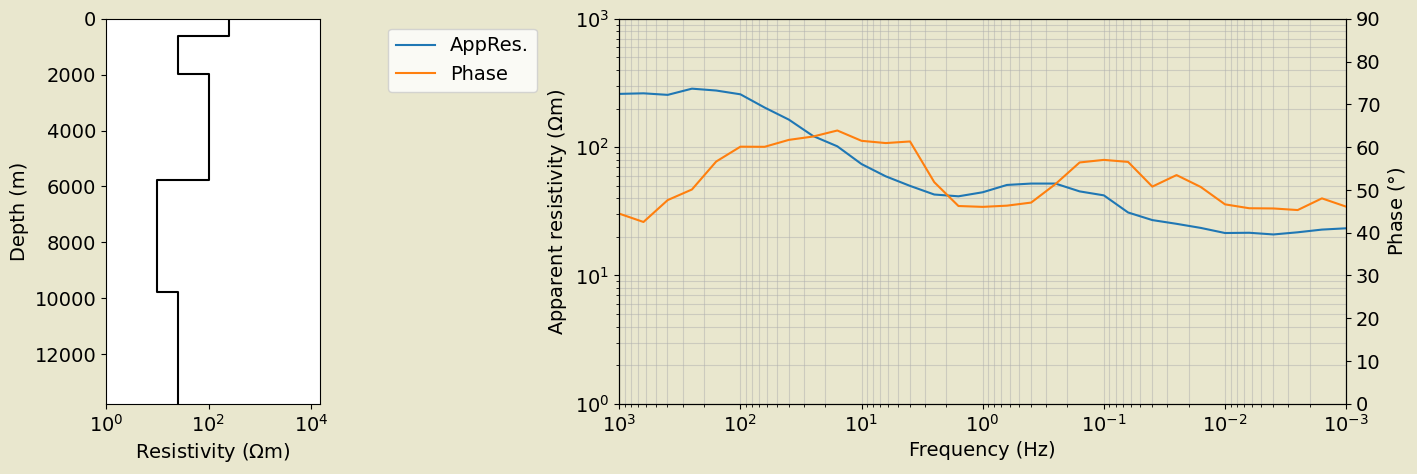

In [5]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
ax0.set_xlabel("Resistivity ($\Omega$m)")
#ax0.set_xlim(1, 1000)
ax0.set_xlim(1, 15000)
# ax0.set_yscale('log')
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency (Hz)")    
ax.set_ylim(1, 1000)
fig.patch.set_facecolor("#e9e7ce")
ax_1.set_facecolor("#e9e7ce")
ax_1.set_ylim(0, 90)    
ax.grid(True, which='both', alpha=0.5)
ax.set_facecolor("#e9e7ce")
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
ax.legend(bbox_to_anchor=(-0.1, 1))
ax.set_xlim(frequencies.max(), frequencies.min())
plt.show()

## Inversión

In [6]:
dz = 100 #100
n_layer = 21 #21
z_factor = 1.2 #1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

print(layer_thicknesses_inv.sum())

rho_app = dobs.reshape((len(frequencies), 2))[:,0]
phase = dobs.reshape((len(frequencies), 2))[:,1]
standard_deviation = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()

rho_0 = 100 #100
rho_ref = 100 #100

output_dict ={}
recovered_model, output_dict = run_smooth_inversion(
    dobs,
    standard_deviation,
    rho_0,
    rho_ref,
    maxIter=20,
    maxIterCG=30,
    alpha_s=1e-10,      
    alpha_z=1,
    beta0_ratio=1,
    coolingFactor=2,
    coolingRate=1,
    chi_factor=1e-2,
)

target_misfit = dobs.size / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']


18668.799962237365

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.10e+01  2.51e+04  0.00e+00  2.51e+04    2.63e+04      0              


c:\Programas\anaconda3\envs\simpeg0170\Lib\site-packages\SimPEG\utils\solver_utils.py:147: UserWarning: tol is not a valid keyword for cg and will be ignored
  warnings.warn(


   1  3.05e+01  2.94e+03  4.24e+00  3.07e+03    2.78e+03      0              
   2  1.53e+01  6.19e+02  1.13e+01  7.92e+02    4.09e+02      0   Skip BFGS  
   3  7.63e+00  2.79e+02  2.18e+01  4.46e+02    2.04e+02      0   Skip BFGS  
   4  3.81e+00  1.44e+02  3.32e+01  2.70e+02    1.14e+02      0   Skip BFGS  
   5  1.91e+00  8.21e+01  4.42e+01  1.66e+02    6.66e+01      0   Skip BFGS  
   6  9.54e-01  5.03e+01  5.57e+01  1.03e+02    4.06e+01      0   Skip BFGS  
   7  4.77e-01  3.38e+01  6.77e+01  6.61e+01    2.47e+01      0   Skip BFGS  
   8  2.38e-01  2.61e+01  7.87e+01  4.49e+01    1.46e+01      0   Skip BFGS  
   9  1.19e-01  2.30e+01  8.77e+01  3.34e+01    8.17e+00      0   Skip BFGS  
  10  5.96e-02  2.17e+01  9.52e+01  2.74e+01    4.36e+00      0   Skip BFGS  
  11  2.98e-02  2.11e+01  1.03e+02  2.41e+01    2.50e+00      0   Skip BFGS  
  12  1.49e-02  2.06e+01  1.13e+02  2.23e+01    2.47e+00      0   Skip BFGS  
  13  7.45e-03  2.04e+01  1.27e+02  2.13e+01    4.20e+00      0 

### Gráfica

#### Curva de Tikhonov

In [7]:
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

interactive(children=(IntSlider(value=20, description='iteration', max=20, min=1), RadioButtons(description='s…

#### Modelo de resistividades

In [8]:
interact(
    plot_inverted_model_and_data, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration)
)

interactive(children=(IntSlider(value=20, description='iteration', max=20, min=1), Output()), _dom_classes=('w…

<function __main__.plot_inverted_model_and_data(iteration)>